### Imports


In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
import requests
import pandas as pd
import numpy as np

## Constants


### Paths to the qrels files and qrels Solr query urls


In [30]:
QREL2_FILE = "../../qrels/q2.txt"

# purple plants (top 20)
QREL2_SIMPLE_URL = "http://localhost:8983/solr/semantic_plants/select?defType=edismax&fl=Name%20Introduction%20Description%20Characteristics&indent=true&q.op=AND&q=purple%20flowers%20NOT(tree)&qf=Description%20Introduction%20Characteristics&rows=20&useParams="
QREL2_BOOSTED_URL = "http://localhost:8983/solr/semantic_plants/select?defType=edismax&fl=Name%20Introduction%20Description%20Characteristics&indent=true&q.op=AND&q=%22purple%20flowers%22~5%20NOT(tree)%20purple%5E2&qf=Description%20Introduction%20Characteristics&rows=20&useParams="


### Store all info


In [31]:
info = {
    "qrel_2": {
        "qrels_file": QREL2_FILE,
    },
}

## Calculate Precision-Recall


In [32]:
def calculate_precision_recall(results, relevant):
    # Calculate precision and recall values
    precision_values = [
        len([doc for doc in results[:idx] if doc in relevant]) / idx
        for idx, _ in enumerate(results, start=1)
    ]

    recall_values = [
        len([doc for doc in results[:idx] if doc in relevant]) / len(relevant)
        for idx, _ in enumerate(results, start=1)
    ]

    precision_recall_match = {k: v for k, v in zip(recall_values, precision_values)}

    # Extend recall_values to include traditional steps for a better curve (0.1, 0.2 ...)
    recall_values.extend(
        [step for step in np.arange(0.1, 1.1, 0.1) if step not in recall_values]
    )
    recall_values = sorted(set(recall_values))  # Sort the values

    # Extend matching dict to include these new intermediate steps
    for idx, step in enumerate(recall_values):
        if step not in precision_recall_match:
            if recall_values[idx - 1] in precision_recall_match:
                precision_recall_match[step] = precision_recall_match[
                    recall_values[idx - 1]
                ]
            else:
                precision_recall_match[step] = precision_recall_match[
                    recall_values[idx + 1]
                ]

    return precision_recall_match, recall_values

## METRICS TABLE

In [33]:
def calculate_metrics(results_file, relevant_file):
    # Read plant names from text files
    with open(results_file, 'r') as file:
        results = [line.strip() for line in file.readlines()]

    with open(relevant_file, 'r') as file:
        relevant = [line.strip() for line in file.readlines()]

    # Calculate metrics
    metrics = {}
    metric = lambda f: metrics.setdefault(f.__name__, f)

    @metric
    def ap(results, relevant):
        # Calculation of Average Precision
        precision_values = []
        relevant_count = 0

        for idx, doc in enumerate(results):
            if doc in relevant:
                relevant_count += 1
                precision_at_k = relevant_count / (idx + 1)
                precision_values.append(precision_at_k)

        if not precision_values:
            return 0.0

        return sum(precision_values) / len(precision_values)

    @metric
    def p10(results, relevant, n=20):
        # Calculation of Precision at N
        return len([doc for doc in results[:n] if doc in relevant]) / n

    def calculate_metric(key, results, relevant):
        return metrics[key](results, relevant)

    # Define metrics to be calculated
    evaluation_metrics = {
        'ap': 'Average Precision',
        'p10': 'Precision at 20 (P@20)'
    }

    # Calculate all metrics and export results as LaTeX table
    df = pd.DataFrame([['Metric', 'Value']] +
                      [[evaluation_metrics[m], calculate_metric(m, results, relevant)]
                       for m in evaluation_metrics])
    return df

## PRECISION-RECALL CURVE

In [34]:
def generate_plots(precision_recall_match, recall_values, type):
    disp = PrecisionRecallDisplay([precision_recall_match.get(r) for r in recall_values], recall_values)
    disp.plot()
    plt.title(f"Q2 {type} Precision-Recall Curve")
    plt.ylim(-0.1, 1.1) 
    # plt.savefig(f'{query_name}_precision_recall.pdf')

## OUTPUTS

                        0         1
0                  Metric     Value
1       Average Precision  0.840678
2  Precision at 20 (P@20)       0.7
                        0         1
0                  Metric     Value
1       Average Precision  0.855269
2  Precision at 20 (P@20)      0.75


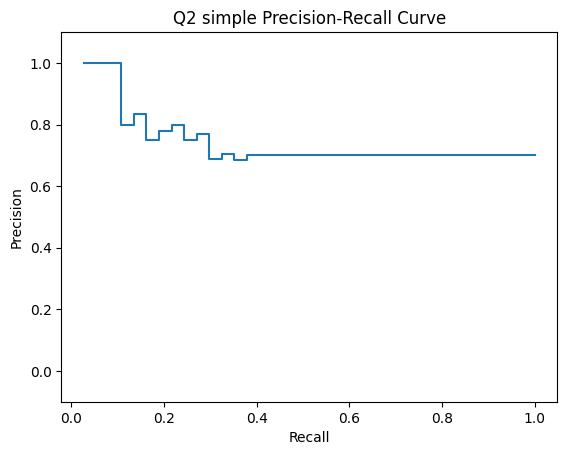

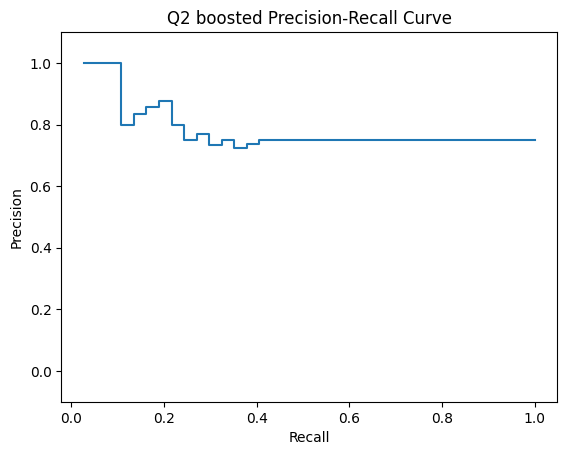

In [35]:
import json

def read_results_from_txt(file_path):
    with open(file_path, 'r') as file:
        results = file.readlines()
        results = [result.strip() for result in results]
        return results

# Read qrels to extract relevant documents
relevant_file = "../../qrels/q2.txt"
relevant = read_results_from_txt(relevant_file)

# Assigning the read data to simple_results and boosted_results
simple_results_file = "./simple_results.txt"
boosted_results_file = "./boosted_results.txt"

simple_results = read_results_from_txt(simple_results_file)
boosted_results = read_results_from_txt(boosted_results_file)

# Calculate precision-recall values for both simple and boosted queries
simple_precision_recall_match, recall_values_simple = calculate_precision_recall(simple_results, relevant)
boosted_precision_recall_match, recall_values_boosted = calculate_precision_recall(boosted_results, relevant)

# Generate plots for both simple and boosted queries
generate_plots(simple_precision_recall_match, recall_values_simple, "simple")
generate_plots(boosted_precision_recall_match, recall_values_boosted, "boosted")

# Calculate metrics for both simple and boosted queries and export results as LaTeX tables
df_simple_metrics = calculate_metrics(simple_results_file, relevant_file)
df_boosted_metrics = calculate_metrics(boosted_results_file, relevant_file)

print(df_simple_metrics)
print(df_boosted_metrics)

with open(f'./results-tex/query2_simple_results.tex', 'w') as tf_simple:
    tf_simple.write(df_simple_metrics.to_latex())

with open(f'./results-tex/query2_boosted_results.tex', 'w') as tf_boosted:
    tf_boosted.write(df_boosted_metrics.to_latex())
